In [223]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import json
import os
import logging
import requests

import functools as ft

from tqdm import tqdm_notebook
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import MeCab

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

%load_ext autoreload
%autoreload 2

logging.basicConfig(level=logging.INFO)

from sklearn.manifold import TSNE
from wordcloud import WordCloud

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
KUCHIKOMI_API = 'https://api.gnavi.co.jp/PhotoSearchAPI/v3/'

# APIの概要を確認

仕様は[こちら](https://api.gnavi.co.jp/api/manual/)

In [21]:
# 機密情報をうっかり流出させないように、別ファイルに保存してあるものを取得
with open('./../gurunabi_api.json','r') as file: 
    api_params=json.load(file)

In [96]:
kuchikomi_params = api_params.copy()
# 取得できるのは最大1000件のみ
# 広すぎると上限数に引掛かかるので300m以内に設定
kuchikomi_params['range'] = 1
kuchikomi_params['latitude'] = '35.681236'
kuchikomi_params['longitude'] = '139.767125'
kuchikomi_params['offset_page'] = '1'

In [97]:
@ft.lru_cache()
def get_kuchikomi_datas():
    data = requests.get(
        KUCHIKOMI_API,
        params = kuchikomi_params
    ).json()
    
    return data

In [98]:
def kuchikomi2df(kuchikomi_data):
    res = kuchikomi_data['response']
    commnts  = []
    num_comment = len(res) -3
    
    for i in range(num_comment):
        com_df = pd.io.json.json_normalize(res[str(i)])
        commnts.append(com_df)
    
    return pd.concat(commnts, ignore_index=True)
    

In [100]:
kuchikomi2df(get_kuchikomi_datas()).head()

,photo.areaname_l,photo.areaname_m,photo.areaname_s,photo.category,photo.comment,photo.distance,photo.image_url.url_1024,photo.image_url.url_200,photo.image_url.url_250,photo.image_url.url_320,photo.latitude,photo.longitude,photo.menu_finish_flag,photo.menu_id,photo.menu_name,photo.messages.first_shop_message.message_body,photo.messages.first_shop_message.send_date,photo.messages.shop_message_count,photo.messages.user_message_count,photo.nickname,photo.photo_genre_id,photo.photo_genre_name,photo.photo_scene_id,photo.photo_scene_name,photo.prefname,photo.shop_id,photo.shop_name,photo.shop_url,photo.total_score,photo.umaso_count,photo.update_date,photo.vote_id
0,東京駅・丸の内・日本橋,東京駅（八重洲）,東京駅（八重洲）,ステーキハンバーグ,すね肉のコリコリした食感が美味。,59,https://mr.gnavi.co.jp/cont/menu_image/88/53/1...,https://mr.gnavi.co.jp/cont/menu_image/88/53/1...,https://mr.gnavi.co.jp/cont/menu_image/88/53/1...,https://mr.gnavi.co.jp/cont/menu_image/88/53/1...,35.681596,139.767608,0,25622,すねバーグ,,,0,0,ぐるなび会員,1,料理・ドリンク,,,PREF13:東京都,1019663,ＳＴＥＡＫ ＆ ＨＡＭＢＵＲＧＶｉｍｏｎ,https://r.gnavi.co.jp/m1vmb2mw0000/?ak=7qF1fl1...,3.0,0,2011-01-25T19:43:46+09:00,169384
1,東京駅・丸の内・日本橋,東京駅（八重洲）,東京駅（八重洲）,ステーキハンバーグ,友人に連れられて伺いました。\r\nボリュームのある粗引き肉のハンバーグで、タルタルステーキ...,59,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,35.681596,139.767608,0,262317,Ｂランチ とろバーグ,,,0,0,puntopunto,1,料理・ドリンク,,,PREF13:東京都,1019663,ＳＴＥＡＫ ＆ ＨＡＭＢＵＲＧＶｉｍｏｎ,https://r.gnavi.co.jp/m1vmb2mw0000/?ak=7qF1fl1...,3.0,0,2011-10-05T22:14:31+09:00,356692
2,東京駅・丸の内・日本橋,東京駅（八重洲）,東京駅（八重洲）,ステーキハンバーグ,肉汁タップリのジューシーなバーグ。\r\n肉自体に味がシッカリ付いているので、そのまま食べて...,59,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,35.681596,139.767608,0,266176,Ａランチ すねバーグ,,,0,0,K_S,1,料理・ドリンク,,,PREF13:東京都,1019663,ＳＴＥＡＫ ＆ ＨＡＭＢＵＲＧＶｉｍｏｎ,https://r.gnavi.co.jp/m1vmb2mw0000/?ak=7qF1fl1...,3.0,0,2011-11-05T22:45:27+09:00,379070
3,東京駅・丸の内・日本橋,東京駅（八重洲）,東京駅（八重洲）,ステーキハンバーグ,ハンバーグの挽肉が荒引きで美味しいです。ステーキを頂いてるみたい。,59,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,https://mr.gnavi.co.jp/cont/menu_image/88/53/3...,35.681596,139.767608,0,262317,Ｂランチ とろバーグ,,,0,0,kyon1120,1,料理・ドリンク,,,PREF13:東京都,1019663,ＳＴＥＡＫ ＆ ＨＡＭＢＵＲＧＶｉｍｏｎ,https://r.gnavi.co.jp/m1vmb2mw0000/?ak=7qF1fl1...,5.0,0,2011-11-15T20:06:14+09:00,398502
4,東京駅・丸の内・日本橋,東京駅（八重洲）,東京駅（八重洲）,ステーキハンバーグ,しっかりとお肉の味がするハンバーグ！付け合わせの野菜もおいしい！,59,https://mr.gnavi.co.jp/cont/menu_image/88/53/4...,https://mr.gnavi.co.jp/cont/menu_image/88/53/4...,https://mr.gnavi.co.jp/cont/menu_image/88/53/4...,https://mr.gnavi.co.jp/cont/menu_image/88/53/4...,35.681596,139.767608,0,266176,Ａランチ すねバーグ,,,0,0,mamikko,1,料理・ドリンク,,,PREF13:東京都,1019663,ＳＴＥＡＫ ＆ ＨＡＭＢＵＲＧＶｉｍｏｎ,https://r.gnavi.co.jp/m1vmb2mw0000/?ak=7qF1fl1...,5.0,0,2011-11-29T23:15:50+09:00,430506


# Datasetの取得

In [262]:
@ft.lru_cache()
def fetch_kuchikomi(lat='35.681236',  lot='139.767125'):
    """指定した緯度経度を中心として、口コミを取得"""
    
    use_columns = ['photo.areaname_l', 'photo.areaname_m', 'photo.areaname_s',
       'photo.category', 'photo.comment', 'photo.distance',
#       'photo.image_url.url_1024', 'photo.image_url.url_200',
#       'photo.image_url.url_250', 'photo.image_url.url_320', 
        'photo.latitude',
       'photo.longitude', 'photo.menu_finish_flag', 'photo.menu_id',
       'photo.menu_name', 
#        'photo.messages.first_shop_message.message_body',
#       'photo.messages.first_shop_message.send_date',
#       'photo.messages.shop_message_count',
       'photo.messages.user_message_count', 'photo.nickname',
       'photo.photo_genre_id', 'photo.photo_genre_name',
       'photo.photo_scene_id', 'photo.photo_scene_name', 'photo.prefname',
       'photo.shop_id', 'photo.shop_name', 'photo.shop_url',
       'photo.total_score', 'photo.umaso_count', 'photo.update_date',
       'photo.vote_id']
    
    kuchikomi_params = api_params.copy()
    # 取得できるのは最大1000件のみ
    # 広すぎると上限数に引掛かかるので300m以内に設定
    kuchikomi_params['range'] = 2
    kuchikomi_params['latitude'] = lat
    kuchikomi_params['longitude'] = lot
    kuchikomi_params['hit_per_page'] = 50

    coms_df_list = []
    kuchikomi_params['offset_page'] = 1
    init_json = requests.get(
                KUCHIKOMI_API,
                params = kuchikomi_params
                ).json()
    total_hit_cnt = int(init_json['response']['total_hit_count'])
    total_page_num = total_hit_cnt//50 
    coms_df_list.append(kuchikomi2df(init_json)) 
    if int(total_hit_cnt) > 1000:
        print('上位千件のみ取得')
             
    for current_num_page in range(2, total_page_num+2):    
        kuchikomi_params['offset_page'] = current_num_page
        try:
            coms_df = kuchikomi2df( 
                    requests.get(
                    KUCHIKOMI_API,
                    params = kuchikomi_params
                    ).json())
        except:
            print('somting occoured')
            continue
            
        coms_df_list.append(coms_df)

    return pd.concat(coms_df_list, ignore_index=True)[use_columns]

In [265]:
place_list = [
    ('35.665751', '139.728687'), # 六本木
    ('35.664738', '139.740295'), # 六本木一丁目
    ('35.67104', '139.734547'), # 赤坂
     ('35.681236', '139.767125')  #丸の内
]

kuchikomis=[]
for lat ,lot in place_list:
    data = fetch_kuchikomi(lat, lot)
    kuchikomis.append(data)
kuchikomi_data = pd.concat(kuchikomis, sort=True)

/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


上位千件のみ取得
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured
somting occoured


In [266]:
kuchikomi_data.head()

,photo.areaname_l,photo.areaname_m,photo.areaname_s,photo.category,photo.comment,photo.distance,photo.latitude,photo.longitude,photo.menu_finish_flag,photo.menu_id,photo.menu_name,photo.messages.user_message_count,photo.nickname,photo.photo_genre_id,photo.photo_genre_name,photo.photo_scene_id,photo.photo_scene_name,photo.prefname,photo.shop_id,photo.shop_name,photo.shop_url,photo.total_score,photo.umaso_count,photo.update_date,photo.vote_id
0,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,バー,,8,35.665697,139.728628,NaN,NaN,NaN,0,わあああああああああああああああ,2,店内・外観,,,PREF13:東京都,6207127,AKIM,https://r.gnavi.co.jp/nd7uum0k0000/?ak=7qF1fl1...,NaN,NaN,2014-06-19T12:51:00+09:00,2000035600
1,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,バー,,8,35.665697,139.728628,NaN,NaN,NaN,0,わあああああああああああああああ,2,店内・外観,,,PREF13:東京都,6207127,AKIM,https://r.gnavi.co.jp/nd7uum0k0000/?ak=7qF1fl1...,NaN,NaN,2014-07-10T13:53:00+09:00,2000038349
2,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,スペイン料理,,16,35.665844,139.728548,NaN,NaN,NaN,0,わあああああああああああああああ,2,店内・外観,,,PREF13:東京都,7628423,La Oliva,https://r.gnavi.co.jp/5ty5xt6z0000/?ak=7qF1fl1...,NaN,NaN,2014-06-17T13:44:00+09:00,2000035393
3,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,スペイン料理,,16,35.665844,139.728548,NaN,NaN,NaN,0,わあああああああああああああああ,2,店内・外観,,,PREF13:東京都,7628423,La Oliva,https://r.gnavi.co.jp/5ty5xt6z0000/?ak=7qF1fl1...,NaN,NaN,2014-07-09T13:24:00+09:00,2000038178
4,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,バー,,19,35.665797,139.728473,NaN,NaN,NaN,0,わあああああああああああああああ,2,店内・外観,9,その他,PREF13:東京都,6144508,KAZUO’S BAR,https://r.gnavi.co.jp/mhvvw85b0000/?ak=7qF1fl1...,NaN,NaN,2014-07-14T13:52:00+09:00,2000038942


# データセットのクレンジング

In [267]:
kuchikomi_data.shape

(2845, 25)

In [306]:
def split_into_words(doc):
    mecab = MeCab.Tagger("-Ochasen -d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
    lines = mecab.parse(doc)
    if not lines:
        return 
    else:
        lines = lines.splitlines()
        words = []
        for line in lines:
            chunks = line.split('\t')
            if len(chunks) > 3 and (chunks[3].startswith('動詞') or chunks[3].startswith('形容詞') 
                                    or chunks[3].startswith('感動詞') or (chunks[3].startswith('名詞') and not chunks[3].startswith('名詞-数'))):
                # 基本形のみを抽出
                words.append(chunks[2])
        return words

In [307]:
split_into_words('あだ名で呼んでもらう時にCall me ○○って使うのでプロダクト名はcallme!にしました。')

['あだ名', '呼ぶ', 'もらう', '時', 'Call', 'Me', '使う', 'プロダクト', '名', 'callme', 'する']

In [269]:
# コメントが存在しない場合の結果を除去する
kuchikomi_data = kuchikomi_data[kuchikomi_data['photo.comment'] !='']
kuchikomi_data.shape

(2322, 25)

In [270]:
kuchikomi_data['wakached']= kuchikomi_data['photo.comment'].apply(split_into_words)

# 学習

## dataset生成

In [271]:
def create_d2v_dataset(tags, token_lists):
    """学習用データ生成""" 
    docs = []
    for tag ,token_list in zip(tags, token_lists):
        docs.append(TaggedDocument(words=token_list, tags=[tag]))
    
    return docs

In [272]:
dataset = create_d2v_dataset(kuchikomi_data['photo.shop_name'].values, kuchikomi_data[ 'wakached'].values)

## モデルの生成

In [273]:
def create_d2v_model(doc_tags):
    model  = Doc2Vec(
                     documents=doc_tags,
                     size=200,
                     min_count=1,
                     iter=5)
        
    return model

In [274]:
model = create_d2v_model(dataset)

/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/gensim/models/doc2vec.py:566: UserWarning: The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.
  warnings.warn("The parameter `iter` is deprecated, will be removed in 4.0.0, use `epochs` instead.")
/Users/hiroaki/.pyenv/versions/3.7.1/envs/pycoon371/lib/python3.7/site-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
INFO:gensim.models.doc2vec:collecting all words and their counts
INFO:gensim.models.doc2vec:PROGRESS: at example #0, processed 0 words (0/s), 0 word types, 0 tags
INFO:gensim.models.doc2vec:collected 6147 word types and 558 unique tags from a corpus of 2322 examples and 38849 words
INFO:gensim.models.word2vec:Loading a fresh vocabulary
INFO:gensim.models.word2vec:effe

# 可視化

In [275]:
d2v_df = pd.DataFrame()
tags = kuchikomi_data['photo.shop_name'].values
for tag in tags:
    d2v_df[tag] = model.docvecs[tag]
d2v_df = d2v_df.T

In [276]:
d2v_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
焼とりの八兵衛六本木店,0.000551,0.003577,-0.003447,-0.002956,-0.006982,-0.003743,-0.007265,-0.006724,-0.002594,0.010050,0.000209,-0.000708,-0.000599,0.006075,0.004234,-0.002816,-0.005760,-0.010880,0.000449,-0.005104,-0.004642,-0.001647,0.005810,-0.002295,-0.001433,-0.001127,-0.001884,0.004266,-0.003223,0.002084,-0.007611,0.003200,-0.003798,0.005713,0.003291,-0.009367,-0.004042,0.008831,0.011499,-0.004583,-0.001520,-0.013914,-0.004744,-0.002326,0.002312,0.009632,0.000997,0.010301,-0.007758,-0.003553,...,0.005642,-0.002886,-0.004016,0.005278,-0.000193,-0.009428,-0.003992,0.008052,0.001682,0.000814,0.002147,0.007555,0.006544,-0.000150,-0.002406,0.001587,0.000672,-0.007941,-0.015523,0.007308,0.000721,0.004158,-0.012287,-0.004363,0.003340,0.005131,-0.004253,-0.003120,-0.000887,-0.000004,0.004105,-0.010182,0.003963,-0.002009,-0.000979,0.008811,0.000066,0.002794,-0.008763,0.000646,0.004643,0.004380,0.001179,0.009774,0.006243,0.009075,-0.000613,-0.004185,-0.016998,0.005670
サブウェイ乃木坂店,-0.002063,0.002292,0.000020,0.000798,-0.004459,-0.001938,-0.003961,-0.004065,0.000139,0.009516,-0.002222,0.001319,0.000241,0.002465,0.004790,-0.001767,-0.003287,-0.006161,0.000457,-0.004369,-0.005049,0.000467,0.004309,-0.002049,0.000849,-0.001163,0.001635,0.000927,-0.003507,-0.002167,-0.006314,0.001066,-0.002600,0.001274,0.000929,-0.004927,-0.004489,0.007875,0.008497,-0.000096,-0.003053,-0.009885,-0.004169,-0.003032,0.003589,0.006869,-0.002066,0.006050,-0.002531,-0.002260,...,0.006352,-0.002845,-0.001427,0.004858,0.002121,-0.009952,-0.005261,0.004090,-0.000316,0.000951,0.002072,0.004863,0.003263,0.000851,-0.003092,0.002875,0.002429,-0.006536,-0.009753,0.006263,-0.002135,0.004503,-0.004718,-0.006773,0.002588,0.001327,-0.001408,-0.004761,-0.003893,0.000127,0.003877,-0.008281,0.006162,-0.004740,0.001602,0.004639,-0.000111,-0.000294,-0.005494,0.002723,0.006617,0.004052,-0.001263,0.007353,0.001702,0.004955,-0.002586,-0.003662,-0.011217,0.004798
らーめん東京食品,-0.012389,0.032369,-0.023916,-0.008229,-0.077947,-0.041843,-0.045062,-0.044345,-0.017233,0.089205,-0.010732,-0.007666,-0.026812,0.047020,0.030458,-0.030006,-0.038459,-0.084559,0.021557,-0.034172,-0.042309,-0.005353,0.058347,-0.014685,-0.007365,-0.017194,0.004763,0.038303,-0.045454,0.003417,-0.049342,0.015081,-0.018256,0.032704,0.006597,-0.089500,-0.044113,0.079827,0.083604,-0.025944,-0.031225,-0.128704,-0.045065,-0.006758,0.035395,0.070018,0.000002,0.094535,-0.050830,-0.026299,...,0.061967,-0.007094,-0.025976,0.064257,0.019723,-0.092757,-0.045392,0.048647,0.001351,0.007722,-0.001999,0.054332,0.040121,-0.003767,-0.016179,0.035465,0.020271,-0.073522,-0.136764,0.055231,-0.012128,0.032521,-0.084949,-0.060228,0.047252,0.025611,-0.028544,-0.046491,-0.019781,0.018255,0.024397,-0.089064,0.049200,-0.033058,0.011913,0.077140,0.001190,0.013459,-0.069749,0.022451,0.059648,0.031977,-0.009380,0.085716,0.048864,0.071537,-0.009855,-0.014759,-0.144814,0.064718
酒呑,-0.002917,0.004733,-0.001737,-0.001395,-0.009531,-0.003200,-0.006430,-0.004606,-0.000163,0.012669,-0.001446,0.000629,-0.002144,0.004072,0.005596,-0.003930,-0.002908,-0.009678,0.001833,-0.005240,-0.004398,-0.001693,0.007166,-0.003288,-0.001061,-0.004328,-0.000864,0.002765,-0.006700,0.000734,-0.004277,0.003450,-0.002346,0.004891,0.002004,-0.012585,-0.008292,0.010535,0.009749,-0.002565,-0.006480,-0.017283,-0.005900,0.000753,0.002754,0.008760,0.001596,0.013611,-0.008283,-0.005337,...,0.010349,-0.003048,-0.001042,0.009029,0.004243,-0.010122,-0.007892,0.004793,-0.000710,0.000477,0.002095,0.005995,0.004512,0.001336,-0.003058,0.006300,0.000921,-0.010452,-0.019398,0.009847,0.000892,0.003385,-0.013896,-0.006536,0.006382,0.004611,-0.005866,-0.007888,-0.

## t-SNEで似たお店同士を可視化する

In [277]:
d2v_2dim = TSNE(n_components=2, n_iter=100000, learning_rate=4).fit_transform(d2v_df)


In [302]:
# ちゃんとzonoがあることを確認
kuchikomi_data[kuchikomi_data['photo.shop_name'].str.contains(r'.*ZONO.*')]

,photo.areaname_l,photo.areaname_m,photo.areaname_s,photo.category,photo.comment,photo.distance,photo.latitude,photo.longitude,photo.menu_finish_flag,photo.menu_id,photo.menu_name,photo.messages.user_message_count,photo.nickname,photo.photo_genre_id,photo.photo_genre_name,photo.photo_scene_id,photo.photo_scene_name,photo.prefname,photo.shop_id,photo.shop_name,photo.shop_url,photo.total_score,photo.umaso_count,photo.update_date,photo.vote_id,wakached
576,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,ラーメン,一度食べてみたかった鳥刺を頂きました。内臓部位の鶏刺がクセなく味わう事ができて感動しました。...,394,35.662203,139.728995,0.0,1098885.0,鶏刺 本日の５点盛り合わせ,0,ぐるなび会員,1,料理・ドリンク,1,友人・同僚と,PREF13:東京都,7009919,炎上鳥麺 ZONO,https://r.gnavi.co.jp/6640rssr0000/?ak=7qF1fl1...,5.0,0.0,2014-08-18T21:36:09+09:00,4579499,"[食べる, みる, 鳥刺し, 頂く, 内臓, 部位, 鶏, 刺, クセ, ない, 味わう, ..."
577,赤坂・六本木・麻布,六本木,六本木（乃木坂方面）,ラーメン,２９歳で独立した店主ZONOが営むお店です。「生食革命」を起こそうとしているそうです。東京じ...,394,35.662203,139.728995,0.0,1099031.0,生食革命〜,0,ぐるなび会員,1,料理・ドリンク,2,宴会,PREF13:東京都,7009919,炎上鳥麺 ZONO,https://r.gnavi.co.jp/6640rssr0000/?ak=7qF1fl1...,5.0,0.0,2014-08-21T05:55:47+09:00,4579653,"[歳, 独立, する, 店主, ZONO, 営む, 店, 生食, 革命, 起こす, する, ..."


In [240]:
shop_name_area_dict = kuchikomi_data[['photo.shop_name', 'photo.areaname_s']].set_index('photo.shop_name').to_dict()
indexs, names = pd.factorize(kuchikomi_data['photo.category'])


{'photo.category': {'ＳＴＥＡＫ ＆ ＨＡＭＢＵＲＧＶｉｍｏｎ': 'ステーキハンバーグ',
  'カーラ アウレリア 大丸東京店': 'サンドイッチ・パン屋',
  'Fairycake Fair': 'カフェ',
  '小岩井農場 エキュート東京店': 'スイーツ',
  'INODA COFFEE 東京大丸支店': 'カフェ',
  '為御菜 東京駅黒塀横丁店': '食堂・定食',
  '銀座ハゲ天 東京駅店': '天ぷら',
  'BURDIGALA CAFE': 'カフェ',
  '築地寿司清 東京グランスタ店': '寿司屋',
  '新橋 鶏繁 どんぶり子': '親子丼',
  'HINT INDEX BOOK エキュート東京店': 'カフェ',
  'もつ焼き 栄司': 'もつ焼き',
  '築地 奈可嶋 お食事処 東京駅黒塀横丁店': '割烹',
  'ひるがお\u3000東京駅店': '塩ラーメン',
  '茶寮 都路里 大丸東京店': 'スイーツ',
  '頂上麺筑紫樓ふかひれ麺専門店': '中華料理',
  '繁乃井東京駅黒塀横丁店': '鶏料理',
  'くしあげ処 串はん 黒塀横丁内': '串揚げ',
  'BURDIGALA EXPRESS 東京GranSta店': 'カフェ',
  '広東炒麺 東京駅店': '広東料理',
  '近爲 大丸東京店': '京料理',
  '越後そば 東京店': 'そば',
  '東京駅 斑鳩': 'ラーメン',
  'Blanc Rouge': 'フレンチ',
  'bar BAR Tokyo': 'ビアレストラン',
  'MOMI＆TOY’S東京駅一番街店': 'カフェ&クレープ',
  'Bar Oak': 'バー',
  '築地すし好 ‐和‐ Nagomiグランスタ丸の内店': '寿司屋 刺身',
  'マダム ブロ 東京駅京葉ストリート店': 'カフェ',
  '京橋千疋屋 東京駅一番街店': 'スイーツ',
  'フルーツパーラー果実園': 'カフェ',
  'mango tree kitchen 東京駅グランスタ': 'タイ料理',
  'シーフードバル Gigas東京駅グランルーフ店': 'シーフード・ワイン',
  'YAMAGATA DINING 山形 酒菜一': 

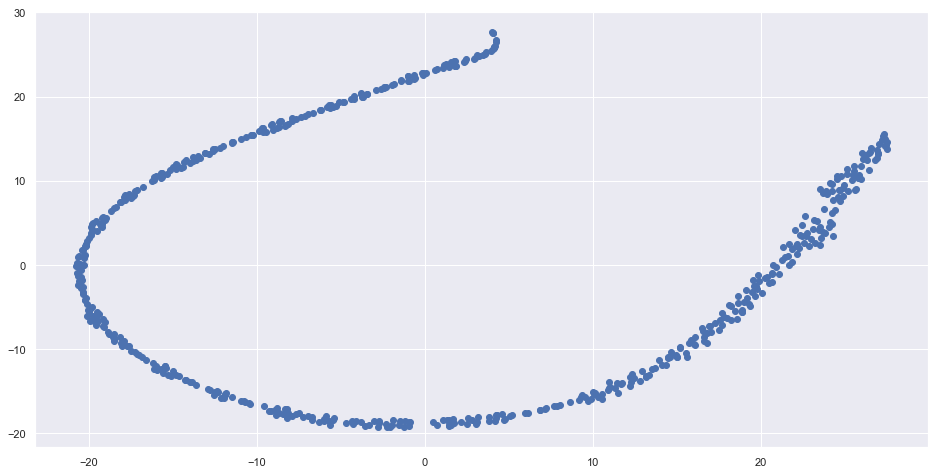

In [293]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.scatter(*d2v_2dim.T,)

In [297]:
len(set(kuchikomi_data['photo.category']))

397